In [4]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/Exp/LR/0.001/experiment1"
REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [2]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8475.26it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8481.09it/s]


In [1]:
import os
autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=200,num_epochs=30)

NameError: name 'AutoEncoder_Generator' is not defined

In [11]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
# eval.eval_boundary_nn_autoencoder(tar_b_features, autoencoder)

In [12]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Wed May 10 23:45:36 2023 Building RP forest with 16 trees
Wed May 10 23:45:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Wed May 10 23:45:38 2023 Building RP forest with 16 trees
Wed May 10 23:45:38 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.18/15 in epoch 200


1.17994

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8326.99it/s]


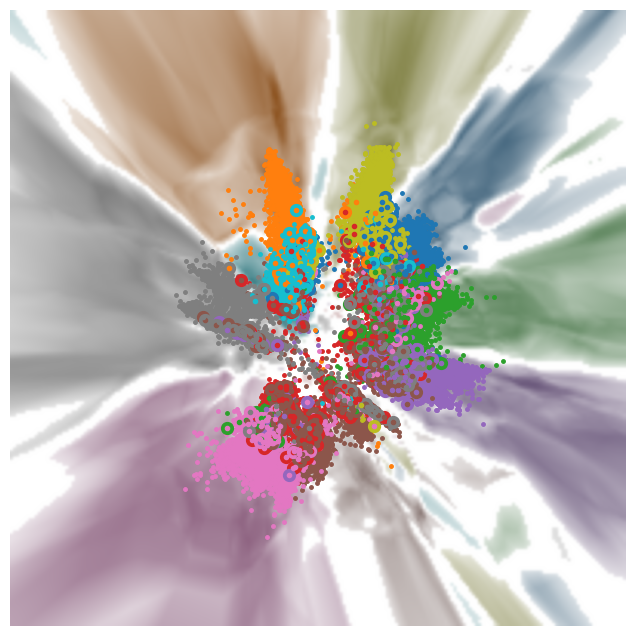

In [13]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [7]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 8460.83it/s]


long distance move subet number is 13789, short distance move set number is 9


100%|██████████| 250/250 [00:00<00:00, 8440.74it/s]


all reference distance preserving 49919/50000
all target distance preserving 40242/50000
short distance move direction preserving 9/9
long distance move direction preserving 11104/13789


In [8]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8527.16it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:34957/50000 0.70
ref&tar pred_same preserving:34546/49262 0.70
ref&tar pred_diff preserving:228/738 0.31


In [ ]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
encoded_Y = autoencoder.encoder(torch.Tensor(tar_train_data))
encoded_Y = encoded_Y.detach().numpy()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(tar_train_data[indicates],encoded_Y[indicates]))